We will use a famous library named TensorFlow (which is now available in version 2+) and in particular one of its subpackages, Keras, together with some utilities libraries like: 

- Matplotlib (for visualization);
- Numpy (to work with arrays);

## GPU Runtime

Neural Network training requires high parallel computation. 


In [1]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Check tensorflow version (must be >2!)
print(tf.__version__)

2024-08-11 12:13:53.194797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


## Read a dataset

To train a Neural Network model, we will need to load in memory a dataset. You can load it in lots of ways, depending on the time of data that you need.

we will use built-in data on keras. In particoular, we are interested in:

- Fashion-MNIST: It is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

we will download the dataset locally and experiment with it.
You can visualize the data [here](https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=fashion_mnist).

In [2]:
# Import keras dataset Fashion Mnist
from tensorflow.keras.datasets import fashion_mnist

# Load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Check data dimensionality
print(f"Training set dimension: Input {x_train.shape}, Output {y_train.shape}")
print(f"Test set dimension: Input {x_test.shape}, Output {y_test.shape}")

Training set dimension: Input (60000, 28, 28), Output (60000,)
Test set dimension: Input (10000, 28, 28), Output (10000,)


We would like our input data to lies in the interval $[0, 1]$. If our data does not lies in this interval, we can transform it as:

$$
x' = \frac{x - x_{min}}{x_{max}-x_{min}}
$$

Where $x_{min} = \min(x)$, $x_{max} = \max(x)$. Note that $x'$ always lies in the interval $[0, 1]$.

In [3]:
#Normalization function
normalize_data = (lambda X: ((X - X.min()) / (X.max() - X.min())))

This operation is called normalization(min-max feature scaling) and allow us to work easily with the data, speeding up the computation and in some case improving even the results of the training.

In [4]:
print(f"Input (train) data lies in the interval [{x_train.min()}, {x_train.max()}]")
print(f"Input (test) data lies in the interval [{x_test.min()}, {x_test.max()}]")
    
x_train = normalize_data(x_train)
x_test = normalize_data(x_test)

# Check the interval after normalization
print("\n")
print(f"Input (train) data lies in the interval [{x_train.min()}, {x_train.max()}]")
print(f"Input (test) data lies in the interval [{x_test.min()}, {x_test.max()}]")

Input (train) data lies in the interval [0, 255]
Input (test) data lies in the interval [0, 255]


Input (train) data lies in the interval [0.0, 1.0]
Input (test) data lies in the interval [0.0, 1.0]


In [5]:
print(f"y[0]: {y_train[0]}")

# One hot encode the output variables (needed to compute the output)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

n_classes = len(y_train[0])

print(f"y[0] after the one-hot encoding: {y_train[0]}")

y[0]: 9
y[0] after the one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Build the first model!

Now that our data is ready, we can build our first model. As you studied, a Neural Network model is defined as a sequence of *Layers*, which is obtained by composing an Affine Transformation with a Non-Linear Activation function. 

The simplest possible layer is the **Dense** layer, which is the fully-connected layer describing the operation $\sigma(Ax + b)$, where $A, b$ are learnable parameters, $A$ is a full matrix, and $\sigma$ is the activation function. Since **Dense** layers applies to vectors (not images), we first need to flatten our data. This can be done either via the **Flatten** layer or via the **Reshape** layer. Moreover, every model must begin with an **Input** layer, that describes the type of data our model will expect as input.

### Summary
- Input: First Layer of the Network.
- Flatten: Utility Layer. It is used to flatten 3-dimensional data of the form $(d_1, d_2, c)$ to a 1-dimensional array of length $d_1 * d_2 * c$. 
- Reshape: Utility Layer. It reshape the input in the way you want, as long as the dimensions match.
- Dense: Basic Layer. It computes a generic Linear transform followed by a non-linear activation function.


In [6]:
# Import Layers from Keras
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

In [7]:
# Sequential API

# Define the model
from tensorflow.keras.models import Sequential

model = Sequential([Flatten(),
                    Dense(units=64, activation='relu'),
                    Dense(units=10, activation='softmax')])

2024-08-11 12:14:05.474369: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-11 12:14:05.475338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-11 12:14:06.749884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 12:14:06.750060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 3.80GiB deviceMemoryBandwidth: 178.84GiB/s
2024-08-11 12:14:06.750077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-08-11 12:14:06.751654: I tensorflow/stream_execut

In [8]:
# Functional API 

"""
This implementation is equivalent to the implemantation above with the Sequential
API, but it is written using Functional API.
"""

def get_model(input_shape, output_shape):
    d1, d2 = input_shape
    # Define the model by concatenating Layers
    x = Input(shape=(d1, d2))

    #h = Flatten()(x)
    h = Reshape((d1*d2,), input_shape=(d1, d2))(x)
    h = Dense(units=64, activation='relu')(h)

    y = Dense(units=output_shape, activation='softmax')(h)

    # Get the model
    model = Model(x, y)

    # Visualize summary of the newly created Model
    model.summary()
    return model

### Why you should use the functional model?

For this small use case both the Sequential and Functional implementations of the model are correct and apparently equivalent. The former is easier to implement, since it is only required to define the ordering of the layers one after the other and Tensorflow will concatenate them to build the Neural Network. The Functional API instead is harder since it requires to define not only the list of the Layers, but also the relationship between them. On the other hand, the Functional API will allow to define architecture with complex relationship between layers (e.g. skip connections), which is impossible while using Sequential API.
One example of the use of skip connections are the Residual Networks. Resnet were proposed by [He et al.](https://arxiv.org/pdf/1512.03385.pdf) in 2015 to solve the image classification problem. In ResNets, the information from the initial layers is passed to deeper layers by matrix addition. This operation doesn’t have any additional parameters as the output from the previous layer is added to the layer ahead. A single residual block with skip connection looks like this:

![Resnet](https://www.researchgate.net/profile/Olarik-Surinta/publication/330750910/figure/fig1/AS:720960386781185@1548901759330/Illustration-of-the-residual-learning-between-a-plain-network-and-b-a-residual.ppm)

## Train the model

To train our model, we first need to **compile** it. Compiling a model means defining a loss function and an optimizer. The loss function should quantify the notion of "distance" we want to minimize in our training, while the optimizer is the algorithm that minimize it.

In symbols, if we define $f(x; \theta)$ our model, parameterized by $\theta$, and we define a loss function $J(\theta) = \frac{1}{N}\sum_{i=1}^N \ell(f(x^{(i)}; \theta), y^{(i)})$, training means finding a set of parameters $\theta^*$ that solves

$$
\theta^* = \arg\min_\theta J(\theta)
$$

This is done by initializing our parameters to a random value $\theta_0$. The default initializer in Keras is Glorot Uniform, but it can be changed. See https://keras.io/api/layers/initializers/ for more informations.
Given $\theta_0$, the Optimizer $g(\cdot)$ computes a sequence of updating:

$$
\theta_{k+1} = \theta_k + \alpha_k g(\theta_k)
$$

where $\alpha_k$ is the *learning rate*.

Compiling a model means defining the loss function $J(\theta)$ (or, equivalently, $\ell(\cdot, \cdot)$), and the optimizer $g(\cdot)$. Other setting will be defined in the compiling phase. We will talk about them later since they are not necessary.

The most used optimizer in the literature is Adam, which is a powerful alternative to the Stochastic Gradient Descent (you already saw in other courses). For a deep explanation on optimizers, refer to https://arxiv.org/abs/1606.04838 . Other optimizier can be choose, for example:

* SGD -> Stochastic Gradient Descent
* RMSprop
* Adadelta
* Adagrad

For an explanation of the different kind of optimizers, refer to the official documentation https://keras.io/api/optimizers/

In [9]:
# Compile the model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

d = x_train.shape[-1]

model = get_model((d, d), y_train.shape[-1])

model.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics='accuracy')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Now that the model is compiled, we can train it. This is done with the *fit* method. To fit the model, we will need some informations.

As we said, training works by minimizing $J(\theta)$ via a sequence of parameters update

$$
\theta_{k+1} = \theta_k + \alpha_k g(\theta_k)
$$

When the optimizer is chosen to be a variant of Stochastic Gradient Descent (SGD) (e.g. Adam), it takes as input a batch of data.

Briefly, consider a dataset of $N$ elemets. Define a parameter $m$, named *batch size* and, at each iteration, select a random subset of data from the entire dataset, of $m$ elements. Those subsets are named *batches*. Given a batch of data, the optimizer takes it as input and compute one step of the training algorithm. Then, the used batch is removed from the original dataset.

After all the dataset is being processed, we say that an *epoch* as been executed. This process is repeated for a (usually fixed) number of epochs. Both the batch size and the number of epochs is passed as input to the *fit* method.

In [10]:
# Train the model. We save the output of the training in a variable named "history".
# This variable contains a report of the behavior of the loss during the iterations.

history = model.fit(x_train, y_train, batch_size=128, epochs=30, validation_split=0.1)

2024-08-11 12:14:20.114569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-11 12:14:20.131363: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3193945000 Hz


Epoch 1/30


2024-08-11 12:14:20.322672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


422/422 [==============================] - 2s 3ms/step - loss: 0.7176 - accuracy: 0.7551 - val_loss: 0.4247 - val_accuracy: 0.8448
Epoch 2/30
422/422 [==============================] - 1s 2ms/step - loss: 0.4094 - accuracy: 0.8513 - val_loss: 0.3893 - val_accuracy: 0.8585
Epoch 3/30
422/422 [==============================] - 1s 2ms/step - loss: 0.3824 - accuracy: 0.8595 - val_loss: 0.4300 - val_accuracy: 0.8415
Epoch 4/30
422/422 [==============================] - 1s 2ms/step - loss: 0.3573 - accuracy: 0.8708 - val_loss: 0.3765 - val_accuracy: 0.8635
Epoch 5/30
422/422 [==============================] - 1s 2ms/step - loss: 0.3408 - accuracy: 0.8725 - val_loss: 0.3707 - val_accuracy: 0.8675
Epoch 6/30
422/422 [==============================] - 1s 2ms/step - loss: 0.3292 - accuracy: 0.8790 - val_loss: 0.3876 - val_accuracy: 0.8633
Epoch 7/30
422/422 [==============================] - 1s 2ms/step - loss: 0.3243 - accuracy: 0.8808 - val_loss: 0.3830 - val_accuracy: 0.8662
Epoch 8/30
422/42

In [11]:
# Compute model accuracy on the test set.
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.8691


[0.4519367218017578, 0.8690999746322632]

It looks like our model performs very good even on new data! Let's see how we can use it to predict a single shape.

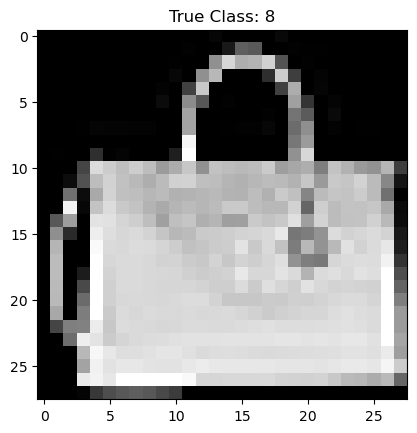

Predicted Class: 8


In [12]:
# Get a single digit and the corresponding label from x_test
n = 30 # Index of the data

x = x_test[n, :, :]
y = y_test[n]

# Visualize the shape
def show(x, y):
    if len(x.shape) == 3:
        x = x[:, :, 0]
    elif len(x.shape) == 4:
        x = x[0, :, :, 0]

    true_class = np.argmax(y)
    
    plt.imshow(x)
    plt.gray()
    plt.title(f"True Class: {true_class}")
    plt.show()

show(x, y)

# We can use the network to predict the value for this digit
y_predict = model.predict(np.expand_dims(x, 0))
shape_predicted = np.argmax(y_predict)

print(f"Predicted Class: {shape_predicted}")

In [14]:
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

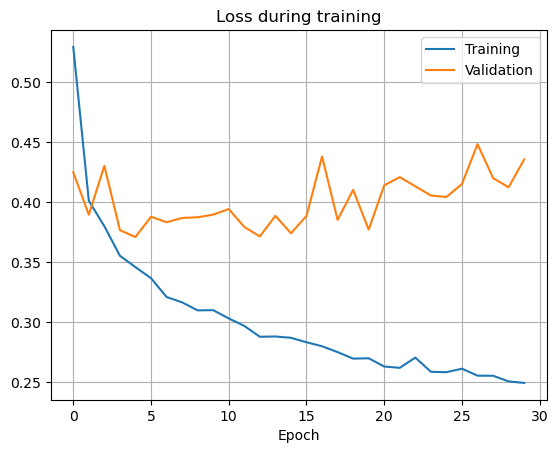

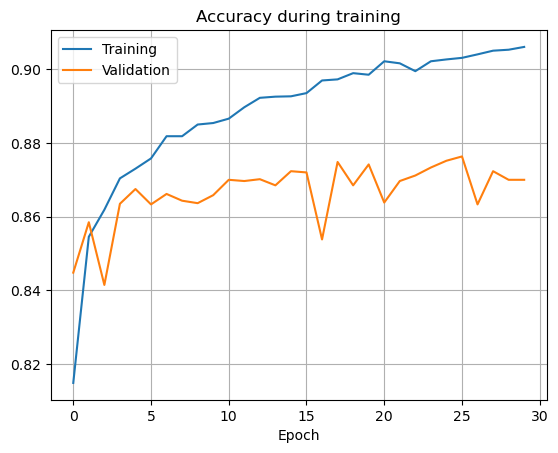

In [15]:
display_history(history)